# Lecture 5: Overfitting and Dropout
Benedikt Auer, Paul Ludwig, Jannik Niebling 

In this notebook, you'll find various tasks encompassing both theoretical and coding exercises. Each exercise corresponds to a specific number of points, which are explicitly indicated within the task description.

Always use the Jupyter kernel associated with the dedicated environment when compiling the notebook and completing your exercises.

## Excercise 1 (Theory) (20/100)

### Bias Variance Tradeoff

Consider the squared loss function commonly used in regression problems, defined as $L(y, \hat{y}) = [(y + \epsilon) - \hat{y}]^2$, where $y$ is the true target value, $\epsilon$ is some random noise and $\hat{y}$ is the predicted value by the model.

- **Task (1.a)** **(10 pts.)** Derive the decomposition of the expected squared error $\mathrm{Err}=E[(y + \epsilon - \hat{y})^2]$ into bias, variance, and irreducible error terms (refer to the lecture for more details).
- **Task (1.b)** **(10 pts.)** Discuss this decomposition in light of the bias-variance tradeoff in machine learning models and in the context of overfitting. What can you say of each single term in the final version you obtain?


> #### Your solution here

Task (1.a)

$\mathrm{Err}=E[(y + \epsilon - \hat{y})^2] = E[y^2 + 2y\epsilon - 2y\hat{y} + \epsilon^2 - 2\epsilon \hat{y} + \hat{y}^2] = y^2-2yE[\hat{y}]+E[\hat{y}]^2-E[\hat{y}]^2+E[\hat{y}^2]+E[\epsilon^2] + 2yE[\epsilon] -2E[\epsilon \hat{y}]$

$=(E[\hat{y}]-y)^2+E[\hat{y}^2]-E[\hat{y}]^2+E[\epsilon^2] + 2yE[\epsilon] -2E[\epsilon \hat{y}] = (\mathrm{Bias}[\hat{y}])^2 +\mathrm{Var}[\hat{y}] + E[\epsilon^2] + 2yE[\epsilon] -2E[\epsilon \hat{y}]$

If the noise is symmetric around 0, the 2nd to last term vanishes. If the noise is independent of the function f (which is suggested by the notation used in the lecture) the last term vanishes. It seems likely that both of these conditions are, in practice, at least approximately fulfilled. In particular, if the first condition is met and $E[\epsilon] = 0$ then both terms may be combinded into $\mathrm{Cov}(\epsilon, \hat{y})$

Task (2.a)

Since the error is the sum of the error inherent to the noise (plus some covariance type term) ,the squared Bias and the variance we can, knowing that variance and bias have a tradeof relationship in ANNs, say that the lower bound on the error consists of 2 parts that are largely independent of eachother. The second part is produced by the fluctuation and is (ignoring the covariance type term) independent of the parameters of the model, while the first part is infact independent of the fluctuation and determined solely by the value of the minimum of the bias variance tradeoff. In particular that means that, even without any fluctuation, a ANN can not pass below a certain threshold of error.

The conditions to make the terms linear in $\epsilon$ vanish was already discussed in the previous part.

## Excercise 2 (Theory) (15/100)

### Bias Variance Tradeoff (part 2)

Consider a regression problem where you have a dataset consisting of $n$ data points where each point consists of a pair $(\mathbf{x}, y)$ with $y=f(\mathbf{x})$. You decide to fit a linear regression model to this dataset. After training the model, you evaluate its performance using mean squared error (MSE). You notice that the model has a high MSE on both the training and test datasets.

- **Task (2.a)** **(5 pts.)** Explain whether the model is suffering from high bias, high variance, or both.
- **Task (2.b)** **(5 pts.)** Propose one approach to decrease the bias and one approach to decrease the variance of the model.
- **Task (2.c)** **(5 pts.)** Provide a justification for each proposed approach.

> #### Your solution here

Task (2.a) 

If the MSE is about equally high on both training and test data then that speaks to a high bias scenario.

If the MSE is high on the test data and also hight but lesser so on the training data, this indicates a hight bias high variance scenario.

Task (2.b+c)

The bias can be decreased increasing the number of parameters in the fitted function. This would (in extreme cases) allow to regression to place all points of the trainig set exactly on the function, making it utterly unusable on the test dataset (#overfitting)

Similarly the variance could be decreased by reducing the number of parameters in the function which would make the fit about equally bad on all data sets.

## Excercise 1 (Programming) (65/100)

### Dropout

The code below loads the CIFAR10 dataset and splits it into train and test datasets

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, 
                                             download=True, transform=transform)
                                             
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, 
                                             download=True, transform=transform)
                                             
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
                                           
# the CIFAR10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### **Task (1.a)** **(10 pts.)** 
From the experience you gained in the previous excercise sheets, implement a neural network choosing arbitrary (based on your intuition) the number of layers, activation functions etc.

Before implementig the NN we take a look at the data:

In [15]:
print(train_dataset[0][0].size())
print(train_dataset[0][1])

torch.Size([3, 32, 32])
6


As we can see, each picture has a resolution of 32x32 pixels. The 3 probably comes from the three color channels of the picture. The second line is the label, also known as the class of the picture. It is a scalar, which is important for the implementation of the cross-entropy loss.

Since we are working in the field of image recognition, we use CNN and pooling layers, even though we haven't covered them in the lecture yet. Because it is a classification task, we apply a softmax function at the end.

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.Conv2 = nn.Conv2d(6, 16, 5)
        self.lin1 = nn.Linear(16 * 5 * 5,120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.Conv1(x))) 
        x = self.pool(F.relu(self.Conv2(x)))  
        x = x.view(-1, 16 * 5 * 5)            # falttens the array 
        x = F.relu(self.lin1(x))               
        x = F.relu(self.lin2(x))  
        x = self.lin3(x)             
        x = F.softmax(  x,dim=1) # used when using my_cross_entropy
                         
        return x

testnet = Net()

### **Task (1.b)** **(10 pts.)** 
For the next task, we want to use the cross-entropy loss as the objective function. Implement the cross-entropy loss from scratch. This should take predicted values and true values as input. 

We implement it as given in the lecture, i.e. between two probability distributions. 
The log function isn't numericly stable, therefore we add a small number of about  the machine perecision, to prevent 0.

In [17]:
def my_cross_entropy(y_pred, y_true):
    log_preds = torch.log(y_pred+1e-11)
    targets_log_probs = log_preds.gather(1, y_true.unsqueeze(1)) # we use the gather function to select the the predicted value that correspond to the right class 
    loss = -targets_log_probs.sum()
    return loss


We test our implementation against the built-in function. The given example is already normalized (i.e., after a softmax layer), so the built-in nn.CrossEntropyLoss() can't be used. Instead, the NLLLoss() function is used. The so-called negative log likelihood loss essentially sums over the values of the true class. When combined with a predicted input of log(y_pred), it mimics the cross-entropy as given in the lecture.

In [18]:
my_test_true = torch.LongTensor([1,0])
my_test_pred =  torch.tensor([[0.001, 0.09, 0.99], [0.99,0.05,0.05] ]) 

test_cross_entropy = nn.NLLLoss(reduction ='sum')
print(test_cross_entropy(torch.log(my_test_pred),my_test_true))
print(my_cross_entropy(my_test_pred,my_test_true))

tensor(2.4180)
tensor(2.4180)


### **Task (1.c)** **(20 pts.)** 
The cell below gives you an implementation for computing the loss on the test data. Implement an appropriate training loop and train the neural network for a sufficient number of epochs. How many training steps you can achieve likely depends on you laptop/device.   

Print the train and test loss after every $n$ steps. In the cell below $n$ is set to 1000 but you are free to change it to any value you think is informative to appreciate the change in the loss. 

> Note: For the more experienced students, you can leverage GPUs (if you have them) to achieve faster computation. Checkout how to achieve this by using the `.to(device)` function in Pytorch.

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
# net = Net()
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum= 0.9)
criterion = my_cross_entropy
n =500
epochs = 150

Using device: cuda:0


In [43]:


def get_test_loss(net, loss_criterion, data_loader):
  testing_loss = []
  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      outputs = net(inputs)
      # calculate the loss for this batch
      loss = loss_criterion(outputs, labels)
      # add the loss of this batch to the list
      testing_loss.append(loss.item())
  # calculate the average loss
  return sum(testing_loss) / len(testing_loss)

In [44]:
training_loss, testing_loss = [], []
running_loss = []

i =  0

## To run on GPUs


# 
# then call any_tensor = any_tensor.to(device)

for epoch in range(epochs): # 150 epochs
  for  data  in train_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # TODO: forward pass
    outputs = net(inputs)
    loss = criterion(outputs,labels)



    # TODO: backward pass & update gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append( loss.item())
    if i % n == 0:
      net.eval()
      avg_train_loss = sum(running_loss) / len(running_loss)
      test_loss = get_test_loss(net, criterion, test_loader)
      testing_loss.append( test_loss)
      training_loss.append( avg_train_loss)
    
      print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}], Current Loss: {running_loss[-1]:.8f}, Avg Loss: {training_loss[-1]:.8f}, Test Loss: {test_loss:.12f}')
      # print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}], Loss: {training_loss[i]}, Test Loss: {testing_loss[i]:.4f}')
      # TODO: store and print avg_train_loss and avg_train_loss every 1000 steps.
      running_loss= []
      net.train()
    i +=1
  

Epoch [1/150], Step [1], Current Loss: 147.79278564, Avg Loss: 147.79278564, Test Loss: 146.766083686974
Epoch [1/150], Step [501], Current Loss: 126.35002136, Avg Loss: 133.14881281, Test Loss: 113.277576009179
Epoch [2/150], Step [1001], Current Loss: 107.20025635, Avg Loss: 104.73468312, Test Loss: 97.952702212486
Epoch [2/150], Step [1501], Current Loss: 85.18937683, Avg Loss: 93.57270673, Test Loss: 87.912507415577
Epoch [3/150], Step [2001], Current Loss: 67.99226379, Avg Loss: 86.71327481, Test Loss: 83.788247199575
Epoch [4/150], Step [2501], Current Loss: 79.62309265, Avg Loss: 81.01300725, Test Loss: 80.816754578025
Epoch [4/150], Step [3001], Current Loss: 70.31295776, Avg Loss: 77.78903931, Test Loss: 77.102712351805
Epoch [5/150], Step [3501], Current Loss: 65.54663849, Avg Loss: 72.65482372, Test Loss: 74.158452380235
Epoch [6/150], Step [4001], Current Loss: 80.63253784, Avg Loss: 71.59022556, Test Loss: 73.136179395542
Epoch [6/150], Step [4501], Current Loss: 80.146789

### **Task (1.d)** **(5 pts.)** 
What are the final values for train and test loss that you achieved? What can you observe regarding e.g., overfitting? Explain (in your own words, no implementation required) how one could in principle improve one loss (or the other, or both) by tuning your network structure, e.g., using regularization, splitting data differently, tuning hyperparameters etc.?

Text(0, 0.5, 'Loss')

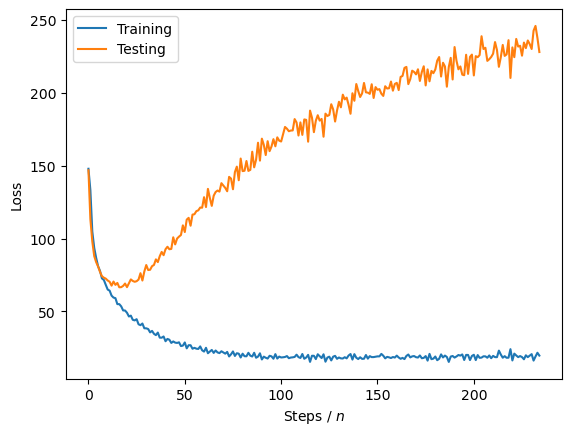

In [45]:
import matplotlib.pyplot as plt
plt.plot(training_loss, label="Training")
plt.plot(testing_loss, label="Testing")
plt.legend()
plt.xlabel(r"Steps / $n$")
plt.ylabel("Loss")

We find an average training loss of about $19.7$ and an average test loss of $227.80$. In the plot above, one can see the average loss as a function of the steps (multiple of $n$). This is a prime example of overfitting. The model learned the features of the training data too well, leading to poor generalization. To reduce the test loss, several things can be done:

One obvious solution would be the use of a larger training set and a smaller test set. The training set used could be a bad representation of the whole dataset and might have, for example, some bias to only include cars, planes, and birds. However, since the used dataset is one of the standard sets, which is widely used to test NNs, that seems unlikely.

Another approach would be to reduce the number of layers and/or neurons. Furthermore, the utilization of a regularizer can reduce the loss of the test data.



### **Task (1.e)** **(20 pts.)**

**Task (1.e.1)** **(15 pts.)**  Pytorch has a class called `torch.nn.Dropout()` which implements Dropout, an efficient regularization technique for preventing overfitting. You can refer to the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more information about it. You have to do some hyperparameters tuning, e.g., dropout probability, amount of dropout layers etc., to identify the best setup.
Using the dropout class, modify the neural network you implemented above in order to incorporate dropout into its structure. Once you have done that, train the modified NN again, similarly to what you have done above. 

**Task (1.e.2)** **(5 pts.)** What are the train and test losses now? What can you observe? Try to plot the losses as a function of epochs/training steps using `matplotlib` or `seaborn` to support your argument. 

In [51]:
class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.Conv2 = nn.Conv2d(6, 16, 5)
        self.lin1 = nn.Linear(16 * 5 * 5,120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.pool(F.relu(self.Conv1(x))) 
        x = self.pool(F.relu(self.Conv2(x)))  
        x = x.view(-1, 16 * 5 * 5)            # falttens the array 
        x = F.relu(self.lin1(x))  
        x=  self.dropout(x)            
        x = F.relu(self.lin2(x))  
        x=  self.dropout(x)            
        x = self.lin3(x)             
        x = F.softmax(  x,dim=1) # used when using my_cross_entropy
                         
        return x

test_net_dropout = NetDropout()

Train the new `net_dropout` model

In [52]:
net_dropout = NetDropout().to(device)
optimizer = optim.SGD(net_dropout.parameters(), lr=0.0001, momentum= 0.9)
training_loss_Drop, testing_loss_Drop = [], []
running_loss = []

i =  0

## To run on GPUs


# 
# then call any_tensor = any_tensor.to(device)

for epoch in range(epochs): # 150 epochs
  for  data  in train_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # TODO: forward pass
    outputs = net_dropout(inputs)
    loss = criterion(outputs,labels)



    # TODO: backward pass & update gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append( loss.item())
    if i % n == 0:
      net_dropout.eval()
      avg_train_loss = sum(running_loss) / len(running_loss)
      test_loss = get_test_loss(net_dropout, criterion, test_loader)
      testing_loss_Drop.append( test_loss)
      training_loss_Drop.append( avg_train_loss)
    
      print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}], Current Loss: {running_loss[-1]:.8f}, Avg Loss: {training_loss_Drop[-1]:.8f}, Test Loss: {test_loss:.12f}')
      # print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}], Loss: {training_loss_Drop[i]}, Test Loss: {testing_loss_Drop[i]:.4f}')
      # TODO: store and print avg_train_loss and avg_train_loss every 1000 steps.
      running_loss= []
      net_dropout.train()
    i +=1

Epoch [1/150], Step [1], Current Loss: 147.03511047, Avg Loss: 147.03511047, Test Loss: 146.770038750521
Epoch [1/150], Step [501], Current Loss: 132.82034302, Avg Loss: 141.77608580, Test Loss: 123.685098137825
Epoch [2/150], Step [1001], Current Loss: 108.59614563, Avg Loss: 113.48161465, Test Loss: 100.377041203201
Epoch [2/150], Step [1501], Current Loss: 112.68447876, Avg Loss: 102.56767938, Test Loss: 93.307659173467
Epoch [3/150], Step [2001], Current Loss: 94.67604065, Avg Loss: 96.43168063, Test Loss: 90.489286046119
Epoch [4/150], Step [2501], Current Loss: 75.07199097, Avg Loss: 92.19070728, Test Loss: 85.236715912060
Epoch [4/150], Step [3001], Current Loss: 87.84976196, Avg Loss: 89.55512157, Test Loss: 82.271850160732
Epoch [5/150], Step [3501], Current Loss: 94.64093018, Avg Loss: 86.65705552, Test Loss: 82.916013146662
Epoch [6/150], Step [4001], Current Loss: 74.04818726, Avg Loss: 83.84661224, Test Loss: 76.662299751476
Epoch [6/150], Step [4501], Current Loss: 90.765

plot the results of the losses as a function of training steps 

Text(0, 0.5, 'Loss')

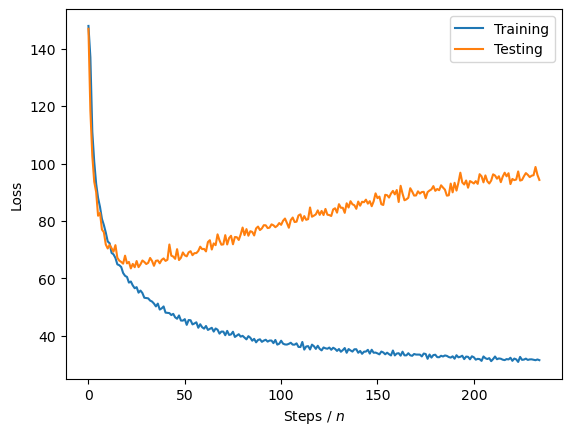

In [48]:



plt.plot(training_loss_Drop, label="Training")
plt.plot(testing_loss_Drop, label="Testing")
plt.legend()
plt.xlabel(r"Steps / $n$")
plt.ylabel("Loss")

In the end, we achieve an average training loss of $39.7$ and an average test loss of $80$. Compared to the case without the dropout layers, we improve our test loss by a factor of approximately 3, but at the same time, we get a training loss that is higher by a factor of 2.

Although the overfitting problem is still present, the dropout layers improved the situation significantly. More tuning of the NN structure is needed to reduce overfitting even further.